In [5]:
import os
os.chdir("/workspace/")
import sys
sys.path.append("/workspace/reni_neus")


import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset
import imageio

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

from reni.reni_config import RENIField
from reni.field_components.field_heads import RENIFieldHeadNames
from reni.data.reni_datamanager import RENIDataManagerConfig, RENIDataManager

def rotation_matrix(axis: np.ndarray, angle: float) -> np.ndarray:
    """
    Return 3D rotation matrix for rotating around the given axis by the given angle.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    rotation = np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    # convert to pytorch
    rotation = torch.from_numpy(rotation).float()
    return rotation

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

reni_ckpt_path = '/workspace/outputs/unnamed/reni/2023-07-25_103550/' # model without vis
step = 50000

ckpt = torch.load(reni_ckpt_path + '/nerfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
reni_model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        reni_model_dict[key[7:]] = ckpt['pipeline'][key]

datamanager: RENIDataManager = RENIField.config.pipeline.datamanager.setup(
    device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank, 
)
datamanager.to(device)

num_train_data = datamanager.num_train
num_eval_data = datamanager.num_eval

# instantiate model with config with vis
model = RENIField.config.pipeline.model.setup(
    scene_box=datamanager.train_dataset.scene_box,
    num_train_data=num_train_data,
    num_eval_data=num_eval_data,
    metadata=datamanager.train_dataset.metadata,
)

model.to(device)
model.load_state_dict(reni_model_dict)
model.eval()

print('Model loaded')

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

Model loaded


In [55]:
i = -1

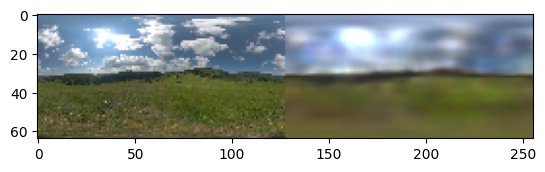

In [2]:
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(7)
H, W = ray_bundle.shape
ray_bundle = ray_bundle.reshape(-1)

rotation = rotation_matrix(np.array([0, 1, 0]), np.deg2rad(0))
rotation = rotation.to(device)

# field_outputs = model.field.forward(ray_bundle, rotation=rotation, latent_codes=torch.randn(1, 36, 3).to(device))
# field_outputs = model.field.forward(ray_bundle, rotation=rotation, latent_codes=torch.zeros(1, 36, 3).to(device))
field_outputs = model.field.forward(ray_bundle, rotation=rotation)

outputs = {
    "rgb": field_outputs[RENIFieldHeadNames.RGB],
    "mu": field_outputs[RENIFieldHeadNames.MU],
    "log_var": field_outputs[RENIFieldHeadNames.LOG_VAR],
}

outputs['rgb'] = outputs['rgb'].reshape(H, W, 3)

metrics_dict, image_dict = model.get_image_metrics_and_images(outputs, batch)

plt.imshow(image_dict['img'].cpu().detach().numpy())

image min: 1.0728836059570312e-05, image max: 22.4273681640625
image min: -11.442575454711914, image max: 3.1102819442749023
percentage of pixels that are the same: 0.9590250651041666
image min: 0.009999999776482582, image max: 11.029999732971191
image min: -4.605170249938965, image max: 2.4006187915802
Dynamic range of img: 2090382.25


/tmp/ipykernel_33861/2383333889.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_filename).astype("float32")


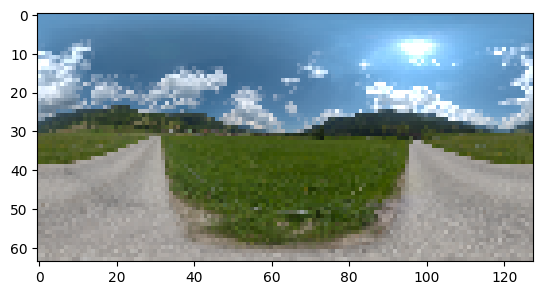

In [53]:
import imageio
from reni.utils.colourspace import linear_to_sRGB
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

# get all file in /workspace/data/RENI_HDR/test ending in .exr
image_filenames = sorted(Path('/workspace/data/RENI_HDR/test').glob('*.exr'))
image_filename = image_filenames[0]
image = imageio.imread(image_filename).astype("float32")
# make any inf values equal to max non inf
image[image == np.inf] = np.nanmax(image[image != np.inf])
# make any values less than zero equal to min non negative
image[image <= 0] = np.nanmin(image[image > 0])

print(f'image min: {np.nanmin(image)}, image max: {np.nanmax(image)}')
# print min max in log domain
print(f'image min: {np.nanmin(np.log(image))}, image max: {np.nanmax(np.log(image))}')

# convert to sRGB
# image = linear_to_sRGB(torch.from_numpy(image)).numpy()

# plort difference between image clipped between 0.01 and 11.03
img_clipped = np.clip(image, 0.01, 11.03)
# print percentage of pixels that are the same
print(f'percentage of pixels that are the same: {np.sum(img_clipped == image) / np.prod(image.shape)}')

print(f'image min: {np.nanmin(img_clipped)}, image max: {np.nanmax(img_clipped)}')
# print min max in log domain
print(f'image min: {np.nanmin(np.log(img_clipped))}, image max: {np.nanmax(np.log(img_clipped))}')

print(f'Dynamic range of img: {np.nanmax(image) / np.nanmin(image)}')

# plot image
image = linear_to_sRGB(torch.from_numpy(image)).numpy()
plt.imshow(image)

In [43]:
print(np.log(1000))

6.907755278982137


In [1]:
from reni.illumination_fields.sh_illumination_field import getCoefficientsFromImage, shReconstructSignal, shEvaluate, SphericalHarmonicIlluminationFieldConfig, SphericalHarmonicIlluminationField
import imageio
from reni.utils.colourspace import linear_to_sRGB
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

image = imageio.imread('/workspace/blue_photo_studio_1k.exr').astype("float32")
# make any inf values equal to max non inf
image[image == np.inf] = np.nanmax(image[image != np.inf])
# make any values less than zero equal to min non negative
image[image <= 0] = np.nanmin(image[image > 0])

/tmp/ipykernel_35981/3709309694.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('/workspace/blue_photo_studio_1k.exr').astype("float32")


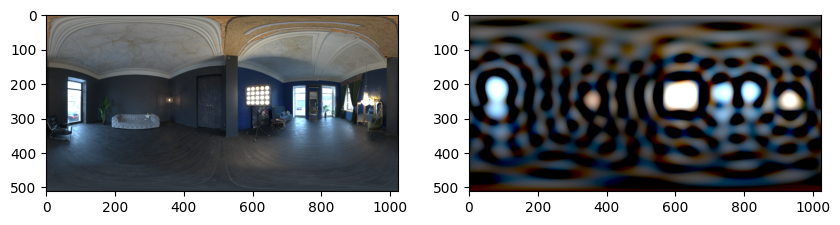

In [2]:
ibl_coeffs = getCoefficientsFromImage(torch.from_numpy(image).to('cpu'), 20, device='cpu')

sh_radiance_map = shReconstructSignal(ibl_coeffs, width=image.shape[1], device='cpu')

# plot image and sh radiance map
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(linear_to_sRGB(torch.from_numpy(image)).numpy())
axs[1].imshow(linear_to_sRGB(sh_radiance_map).cpu().detach().numpy())

In [3]:
config = SphericalHarmonicIlluminationFieldConfig(
    spherical_harmonic_order=20,
)

sh_field = SphericalHarmonicIlluminationField(config=config, num_train_data=1, num_eval_data=1)
sh_field.train_latent_codes.data = ibl_coeffs.unsqueeze(0).to('cpu')
sh_field.eval_latent_codes.data = ibl_coeffs.unsqueeze(0).to('cpu')

In [4]:
from nerfstudio.cameras.cameras import Cameras, CameraType

cx = torch.tensor(1000 // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(500 // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(500, dtype=torch.float32).repeat(1)
fy = torch.tensor(500, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[-1, 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)
                     

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(camera_indices=0, keep_shape=True)
ray_bundle.camera_indices = ray_bundle.camera_indices.to('cpu').reshape(-1)
ray_bundle.directions = ray_bundle.directions.to('cpu').reshape(-1, 3)

output = sh_field.forward(ray_bundle)

RuntimeError: einsum(): subscript j has size 441 for operand 1 which does not broadcast with previously seen size 9

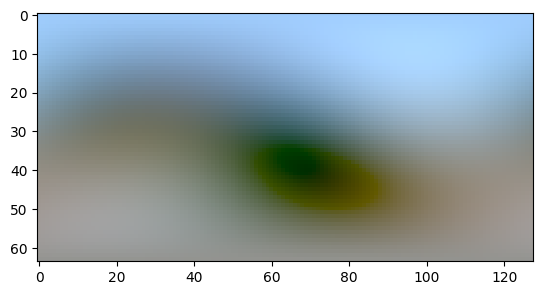

In [29]:
radiance = radiance.reshape(64, 128, 3)
# plot radiance
plt.imshow(linear_to_sRGB(radiance).cpu().detach().numpy())

In [26]:
ibl_coeffs.shape

torch.Size([9, 3])

In [11]:
from reni.illumination_fields.sh_illumination_field import getCoefficientsFromImage, shReconstructSignal, shEvaluate
from reni.illumination_fields.environment_map_field import EnvironmentMapField, EnvironmentMapFieldConfig
from reni.field_components.field_heads import RENIFieldHeadNames
import imageio
from reni.utils.colourspace import linear_to_sRGB
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

import os
os.chdir("/workspace/")
import sys
sys.path.append("/workspace/reni_neus")

In [12]:
config = EnvironmentMapFieldConfig(
    path='/workspace/blue_photo_studio_1k.exr',
    resolution=(64, 128),
    trainable=False,
    apply_padding=True,
    fixed_decoder=True
)

envmap_field = EnvironmentMapField(config, 10, 10)
envmap_field = envmap_field.to('cpu')
equiH = envmap_field.train_envmaps.shape[2]
equiW = 2 * equiH

In [13]:
from nerfstudio.cameras.cameras import Cameras, CameraType

cx = torch.tensor(equiW // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(equiH // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(equiH, dtype=torch.float32).repeat(1)
fy = torch.tensor(equiH, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[-1, 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)
                     

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(camera_indices=0, keep_shape=True)
ray_bundle.camera_indices = ray_bundle.camera_indices.to('cpu').reshape(-1)
ray_bundle.directions = ray_bundle.directions.to('cpu').reshape(-1, 3)

output = envmap_field.forward(ray_bundle, rotation=None)

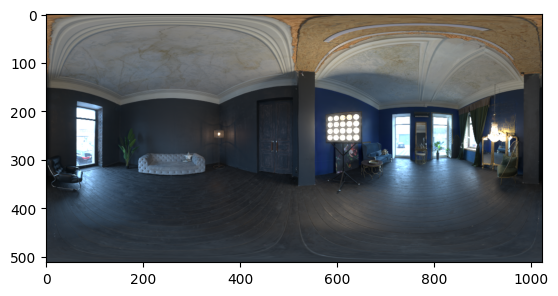

In [14]:
img = output[RENIFieldHeadNames.RGB].reshape(equiH, equiW, 3)
plt.imshow(linear_to_sRGB(img).cpu().detach().numpy())

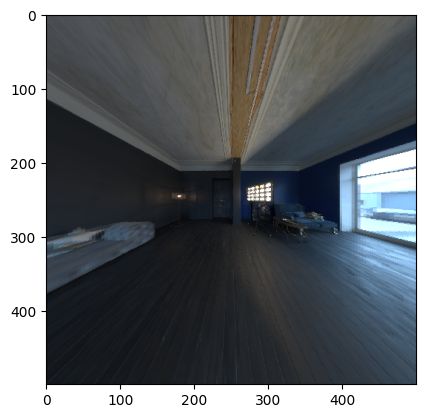

In [17]:
import torch

from nerfstudio.cameras.cameras import Cameras

from reni_neus.reni_neus.utils.utils import look_at_target

camera_positions = torch.tensor([[0.0, 1.0, 0.0]])

target_positions = torch.tensor([[0.0, 0.0, 0.0]])

c2w = look_at_target(camera_positions, target_positions, up_vector=torch.tensor([0.0, 0.0, 1.0]))[:, :3, :]

H, W = 500, 500
fx, fy = 50.0, 50.0
cx, cy = W / 2, H / 2

camera = Cameras(camera_to_worlds=c2w, fx=fx, fy=fy, cx=cx, cy=cy)

ray_bundle = camera.generate_rays(camera_indices=0, keep_shape=True)

ray_bundle.camera_indices = ray_bundle.camera_indices.to('cpu').reshape(-1)
ray_bundle.directions = ray_bundle.directions.to('cpu').reshape(-1, 3)

output = envmap_field.forward(ray_bundle)
img = output[RENIFieldHeadNames.RGB].reshape(500, 500, 3)
plt.imshow(linear_to_sRGB(img).cpu().detach().numpy())